In [17]:
import pandas as pd
import bnlearn as bn

#load processed data (location fire hazard, precipitation, powerplants, earthquake)
# Assuming the CSV file is in the same directory as your script or Jupyter notebook
file_path = 'geo_fire_precip_gen_eq.csv'

# Read the CSV file into a pandas DataFrame
df_geo= pd.read_csv(file_path)

# Assuming the CSV file is in the same directory as your script or Jupyter notebook
#load processed data (state, precipitation, disaster declrations, power disturbances)
file_path = 'state_precip_disas_break_.csv'

# Read the CSV file into a pandas DataFrame
df_month= pd.read_csv(file_path)

Accuracy: 0.7692307692307693
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.83      0.87        35
           1       0.14      0.25      0.18         4

    accuracy                           0.77        39
   macro avg       0.52      0.54      0.52        39
weighted avg       0.83      0.77      0.80        39



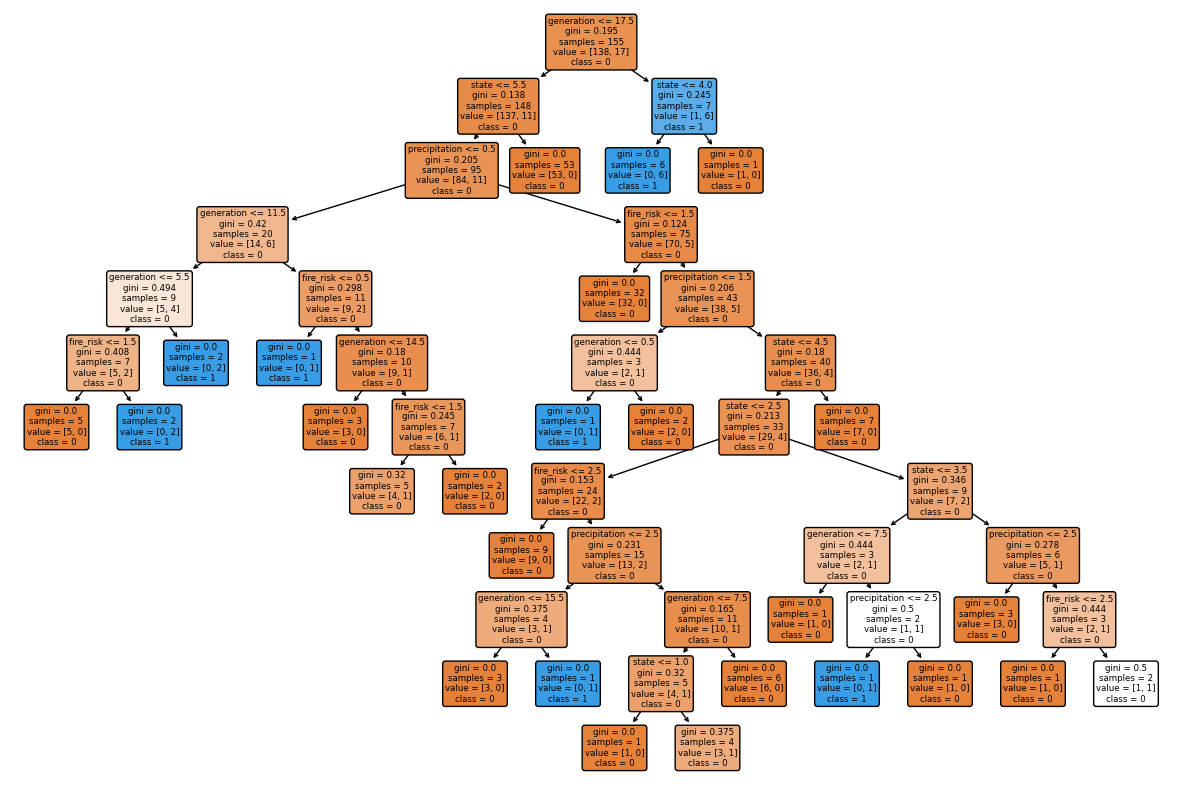

In [18]:

#%% Train classical decision tree for fire risk
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Assuming df_geo is your DataFrame
# Let's encode the categorical variables using LabelEncoder
le_state = LabelEncoder()
le_generation = LabelEncoder()
le_fire_risk = LabelEncoder()

df_geo['state'] = le_state.fit_transform(df_geo['state'])
df_geo['generation'] = le_generation.fit_transform(df_geo['generation'])
df_geo['fire_risk'] = le_fire_risk.fit_transform(df_geo['fire_risk'])

# Extract features and target variable
X_categorical = df_geo[['state', 'generation', 'fire_risk']]
X_numeric = df_geo[['precipitation']]  # Add other numeric columns as needed

# Concatenate categorical and numeric features
X = pd.concat([X_categorical, X_numeric], axis=1)

y = df_geo['earthquake risk']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Decision Tree model
model = DecisionTreeClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report_str)

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Assuming 'model' is your trained Decision Tree model
class_names_str = list(map(str, model.classes_))

plt.figure(figsize=(15, 10))
plot_tree(model, feature_names=list(X.columns), class_names=class_names_str, filled=True, rounded=True)
plt.show()


Accuracy NB: 0.8974358974358975
Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95        35
           1       0.00      0.00      0.00         4

    accuracy                           0.90        39
   macro avg       0.45      0.50      0.47        39
weighted avg       0.81      0.90      0.85        39



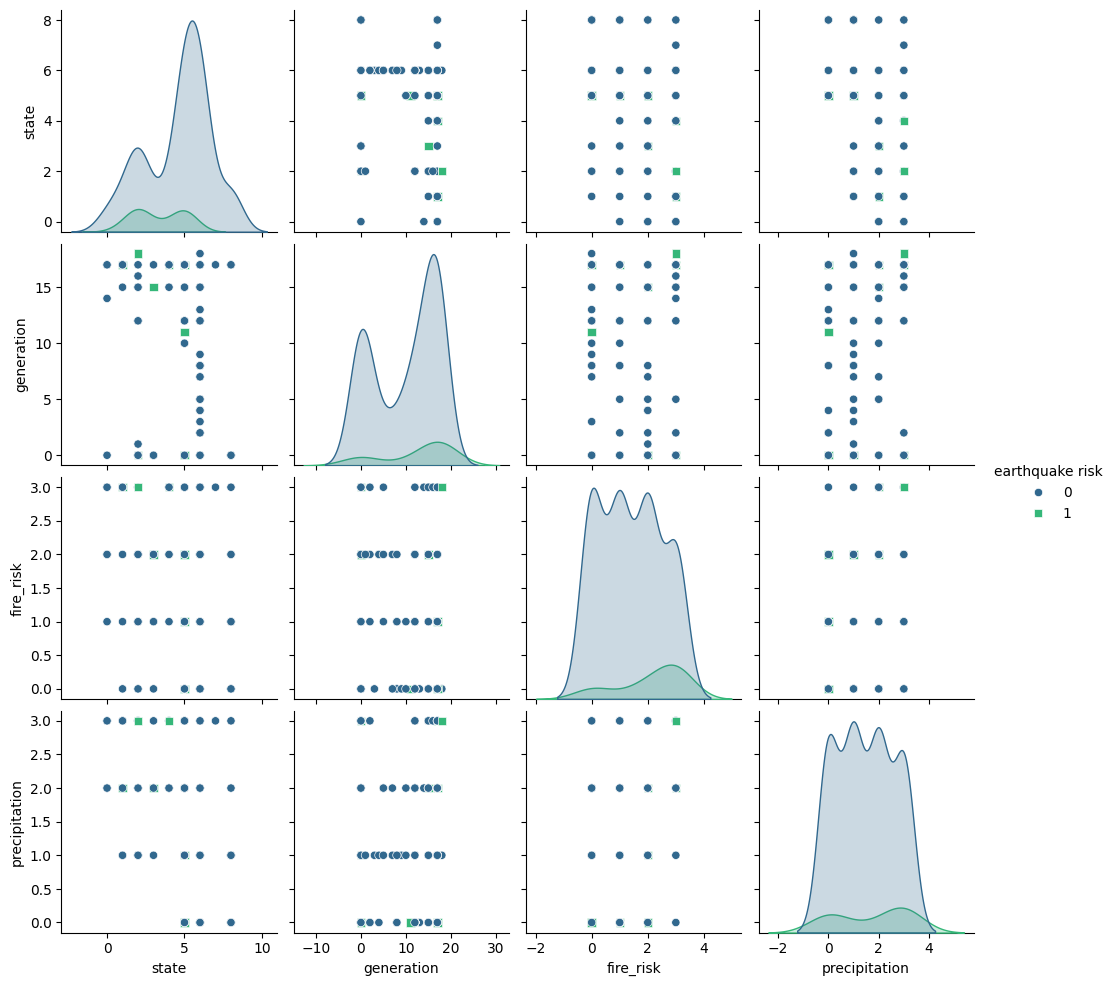

In [19]:
#%% Train naive-bayes for fire risk
# Import necessary libraries for Naive Bayes
from sklearn.naive_bayes import GaussianNB


# Create a Naive Bayes model (Gaussian Naive Bayes for continuous features)
model = GaussianNB()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy NB: {accuracy}")
print("Classification Report:\n", classification_report_str)


import seaborn as sns

# Concatenate features and target variable for training data
train_data = pd.concat([X_train, y_train], axis=1)

# Pair plot
sns.pairplot(train_data, hue='earthquake risk', palette='viridis', markers=["o", "s", "D"])
plt.show()



In [20]:
#%% Train DNN for fire risk

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train.values)
y_train_tensor = torch.LongTensor(y_train.values)
X_test_tensor = torch.FloatTensor(X_test.values)
y_test_tensor = torch.LongTensor(y_test.values)

# Create a DataLoader for training and testing data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Define the neural network
class EarthquakeRiskComplexNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(EarthquakeRiskComplexNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x

# Example usage:
hidden_size1 = 64
hidden_size2 = 32
hidden_size3 = 16

# Instantiate the model
input_size = X_train.shape[1]
output_size = len(class_names_str)  # Number of classes
model = EarthquakeRiskComplexNN(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 10
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Evaluate the model
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)

    print(f"Accuracy_NN: {accuracy}")

# Set the model back to training mode
model.train()

from sklearn.metrics import classification_report
import torch

# Assuming you have the true labels (y_test) and predicted labels (predicted)
# Convert tensors to numpy arrays
y_test_np = y_test_tensor.numpy()
predicted_np = predicted.numpy()

# Generate classification report
report = classification_report(y_test_np, predicted_np)

# Print the report
print(report)


Accuracy_NN: 0.8974358974358975
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        35
           1       0.00      0.00      0.00         4

    accuracy                           0.90        39
   macro avg       0.45      0.50      0.47        39
weighted avg       0.81      0.90      0.85        39



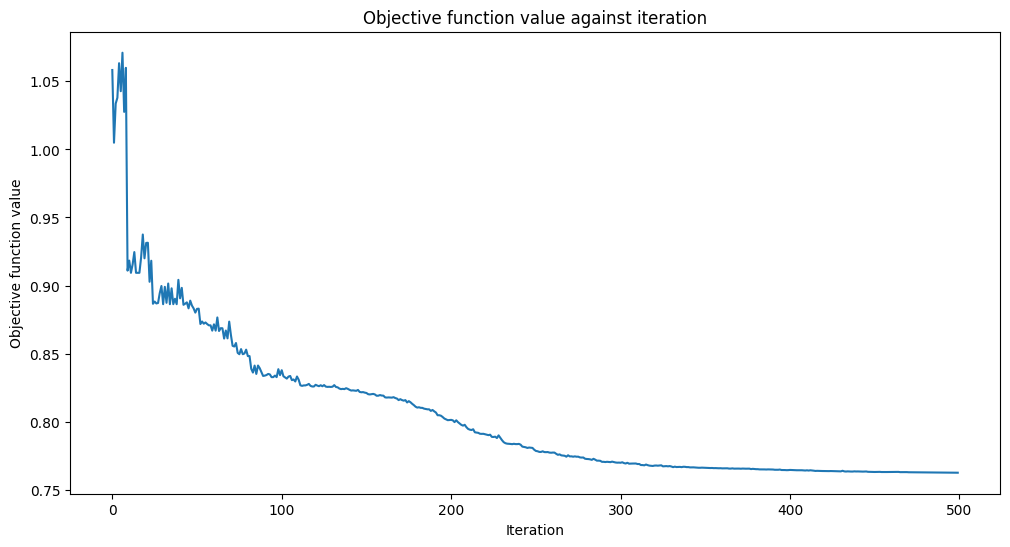

Predicted labels: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1
 0 0]
Ground truth:     [0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0]


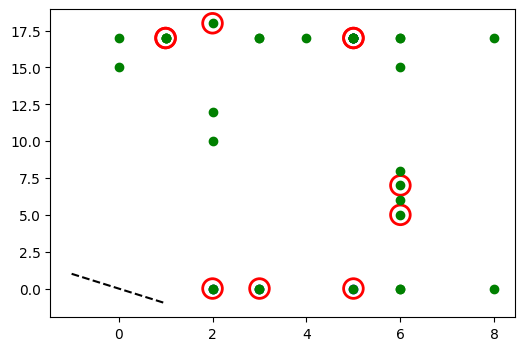

In [21]:
#%%   Train Quantum NN for Fire risk

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit

algorithm_globals.random_seed = 42
qc = QNNCircuit(num_qubits=4)
qc.draw("mpl", style="clifford")
estimator_qnn = EstimatorQNN(circuit=qc)
print(X_train.values[0])
estimator_qnn.forward(X_train.values[0], algorithm_globals.random.random(estimator_qnn.num_weights))


# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()


vqc = VQC(
    num_qubits=4,
    optimizer=COBYLA(maxiter=500),
    callback=callback_graph,
)

    # construct neural network classifier
estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=60), callback=callback_graph
)

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

y_cat = np.empty(y_train.values.shape, dtype=str)
y_cat[y_train.values == 0] = "A"
y_cat[y_train.values == 1] = "B"
y_cat[y_train.values == 2] = "C"
print(y_cat)

# fit classifier to data
vqc.fit(X_train.values, y_train.values)


# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(X_train.values,y_train.values)


predict = vqc.predict(X_test.values)
print(f"Predicted labels: {predict}")
print(f"Ground truth:     {y_test.values}")

# evaluate data points
y_predict =predict

# # plot results
# # red == wrongly classified
# for x, y_target, y_p in zip(X_test.values, y_test.values, y_predict):
#     if y_target == 1:
#         plt.plot(x[0], x[1], "bo")
#     else:
#         plt.plot(x[0], x[1], "go")
#     if y_target != y_p:
#         plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
# plt.plot([-1, 1], [1, -1], "--", color="black")
# plt.show()


from sklearn.metrics import classification_report
import torch

# Assuming you have the true labels (y_test) and predicted labels (predicted)
# Convert tensors to numpy arrays
y_test_np = y_test.values
predicted_np = predict

# Generate classification report
report = classification_report(y_test_np, predicted_np)

# Print the report
print(report)


Accuracy: 0.358974358974359
Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.25      0.27         8
           1       0.31      0.45      0.37        11
           2       0.20      0.25      0.22         8
           3       0.83      0.42      0.56        12

    accuracy                           0.36        39
   macro avg       0.41      0.34      0.35        39
weighted avg       0.44      0.36      0.38        39



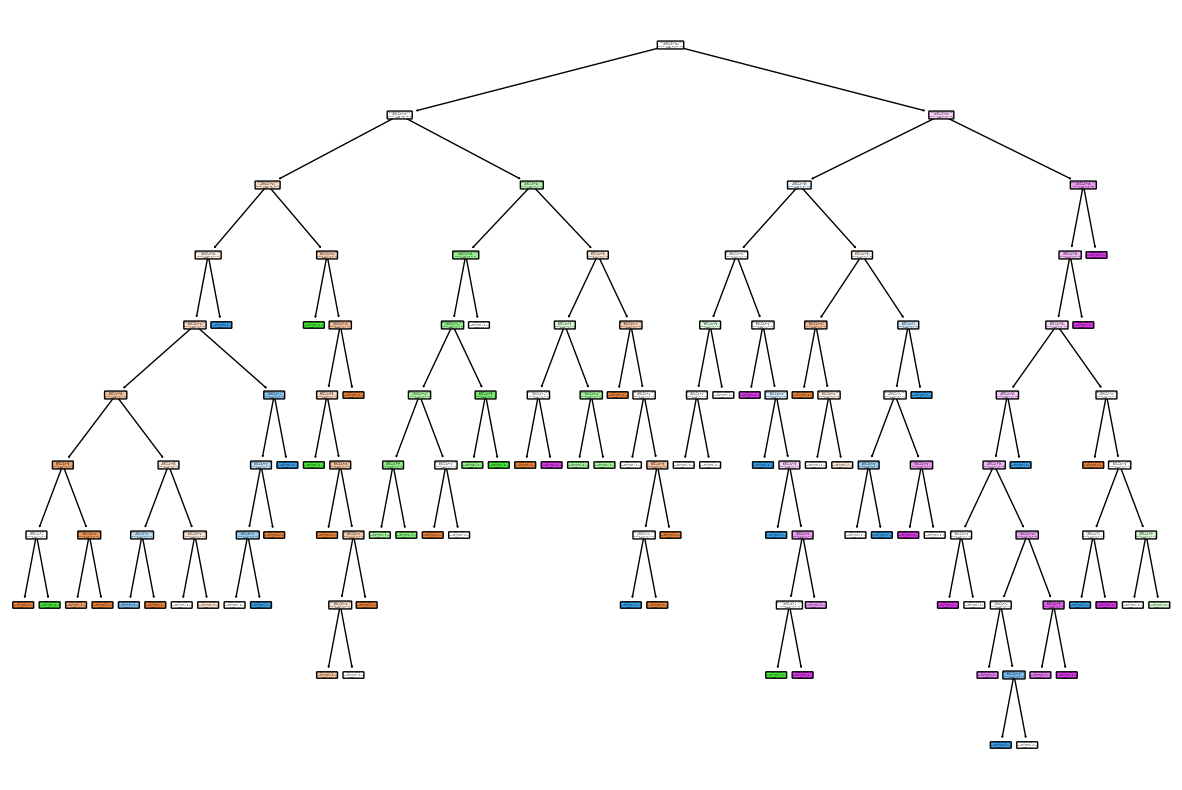

In [22]:
#%%  Train decision tree for Earthquake risk

# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Assuming df_geo is your DataFrame
# Let's encode the categorical variables using LabelEncoder
le_state = LabelEncoder()
le_generation = LabelEncoder()
le_fire_risk = LabelEncoder()

df_geo['state'] = le_state.fit_transform(df_geo['state'])
df_geo['generation'] = le_generation.fit_transform(df_geo['generation'])
df_geo['fire_risk'] = le_fire_risk.fit_transform(df_geo['fire_risk'])

# Extract features and target variable
X_categorical = df_geo[['state', 'generation', 'earthquake risk']]
X_numeric = df_geo[['precipitation']]  # Add other numeric columns as needed

# Concatenate categorical and numeric features
X = pd.concat([X_categorical, X_numeric], axis=1)

y = df_geo['fire_risk']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Decision Tree model
model = DecisionTreeClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report_str)

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Assuming 'model' is your trained Decision Tree model
class_names_str = list(map(str, model.classes_))

plt.figure(figsize=(15, 10))
plot_tree(model, feature_names=list(X.columns), class_names=class_names_str, filled=True, rounded=True)
plt.show()


Accuracy NB: 0.4358974358974359
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.50      0.44         8
           1       0.33      0.36      0.35        11
           2       0.00      0.00      0.00         8
           3       0.69      0.75      0.72        12

    accuracy                           0.44        39
   macro avg       0.36      0.40      0.38        39
weighted avg       0.39      0.44      0.41        39



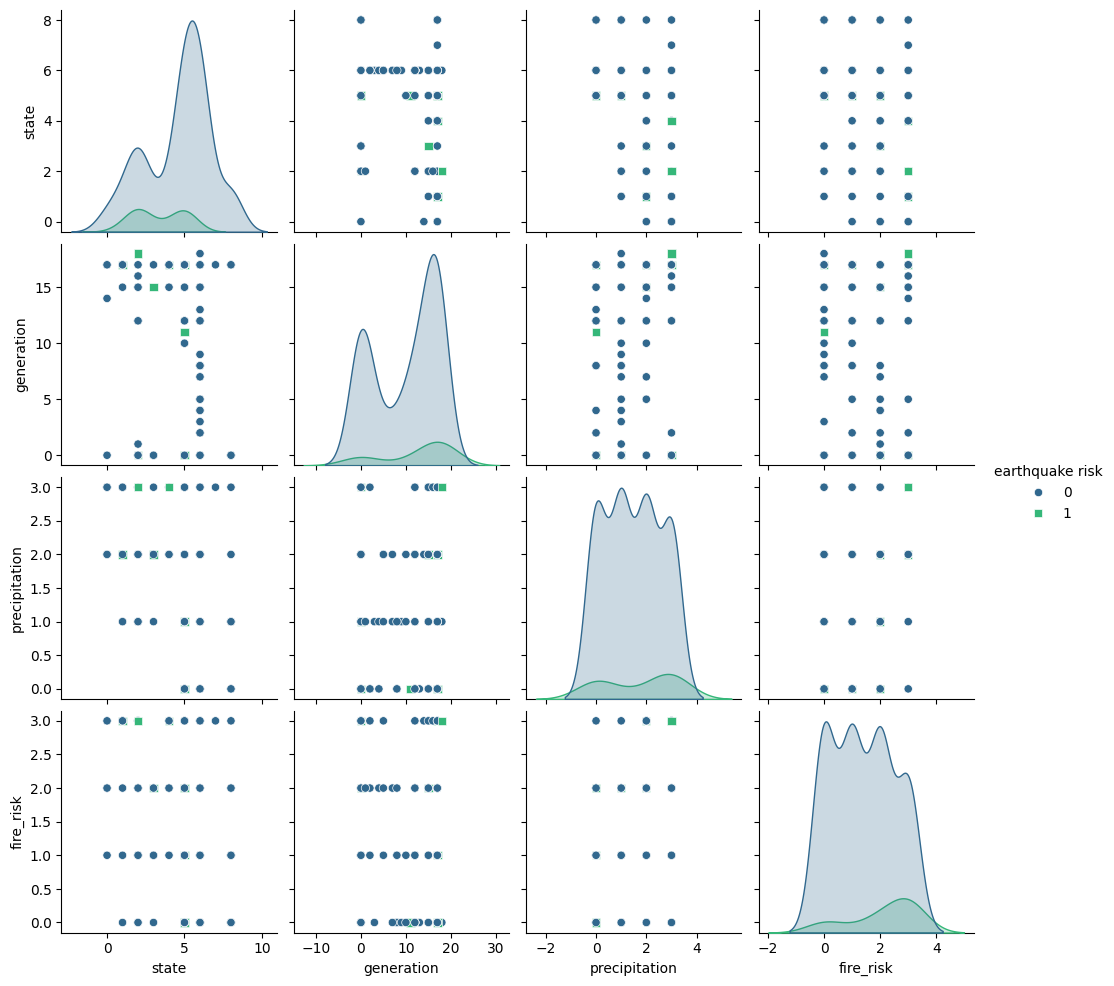

In [23]:
#%% Train naive-bayes for Earthquake risk


# Import necessary libraries for Naive Bayes
from sklearn.naive_bayes import GaussianNB


# Create a Naive Bayes model (Gaussian Naive Bayes for continuous features)
model = GaussianNB()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy NB: {accuracy}")
print("Classification Report:\n", classification_report_str)

import seaborn as sns

# Concatenate features and target variable for training data
train_data = pd.concat([X_train, y_train], axis=1)

# Pair plot
sns.pairplot(train_data, hue='earthquake risk', palette='viridis', markers=["o", "s", "D"])
plt.show()

In [24]:
#%%  Train DNN for Earthquake risk

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train.values)
y_train_tensor = torch.LongTensor(y_train.values)
X_test_tensor = torch.FloatTensor(X_test.values)
y_test_tensor = torch.LongTensor(y_test.values)

# Create a DataLoader for training and testing data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Define the neural network
class EarthquakeRiskComplexNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(EarthquakeRiskComplexNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x

# Example usage:
hidden_size1 = 64
hidden_size2 = 32
hidden_size3 = 16

# Instantiate the model
input_size = X_train.shape[1]
output_size = len(class_names_str)  # Number of classes
model = EarthquakeRiskComplexNN(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 100
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Evaluate the model
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)

    print(f"Accuracy_NN: {accuracy}")

# Set the model back to training mode
model.train()

from sklearn.metrics import classification_report
import torch

# Assuming you have the true labels (y_test) and predicted labels (predicted)
# Convert tensors to numpy arrays
y_test_np = y_test_tensor.numpy()
predicted_np = predicted.numpy()

# Generate classification report
report = classification_report(y_test_np, predicted_np)

# Print the report
print(report)

Accuracy_NN: 0.46153846153846156
              precision    recall  f1-score   support

           0       0.33      0.38      0.35         8
           1       0.22      0.18      0.20        11
           2       0.40      0.25      0.31         8
           3       0.69      0.92      0.79        12

    accuracy                           0.46        39
   macro avg       0.41      0.43      0.41        39
weighted avg       0.42      0.46      0.43        39



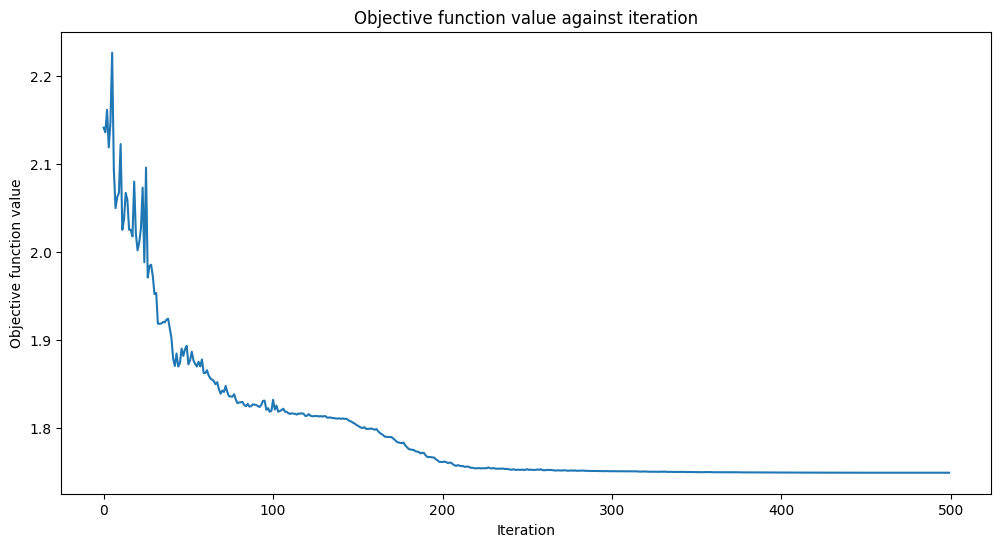

Predicted labels: [0 0 0 2 0 1 3 0 3 3 0 0 1 3 0 1 3 0 1 2 0 3 3 0 3 3 2 2 1 1 1 0 0 3 0 0 2
 2 3]
Ground truth:     [2 0 3 3 2 1 3 0 3 3 0 1 0 3 1 1 2 3 1 3 1 2 2 2 2 0 1 3 1 2 1 3 1 3 1 0 0
 0 3]


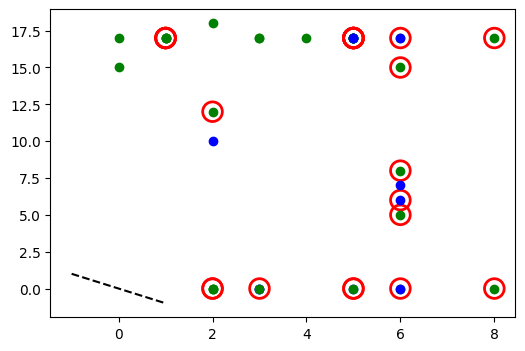

In [25]:
#%%   Train Quantum NN for Earthquake risk

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit

algorithm_globals.random_seed = 42
qc = QNNCircuit(num_qubits=4)
qc.draw("mpl", style="clifford")
estimator_qnn = EstimatorQNN(circuit=qc)
print(X_train.values[0])
estimator_qnn.forward(X_train.values[0], algorithm_globals.random.random(estimator_qnn.num_weights))


# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()


vqc = VQC(
    num_qubits=4,
    optimizer=COBYLA(maxiter=500),
    callback=callback_graph,
)

    # construct neural network classifier
estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=60), callback=callback_graph
)

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

y_cat = np.empty(y_train.values.shape, dtype=str)
y_cat[y_train.values == 0] = "A"
y_cat[y_train.values == 1] = "B"
y_cat[y_train.values == 2] = "C"
print(y_cat)

# fit classifier to data
vqc.fit(X_train.values, y_train.values)


# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(X_train.values,y_train.values)


predict = vqc.predict(X_test.values)
print(f"Predicted labels: {predict}")
print(f"Ground truth:     {y_test.values}")

# evaluate data points
y_predict =predict

# # plot results
# # red == wrongly classified
# for x, y_target, y_p in zip(X_test.values, y_test.values, y_predict):
#     if y_target == 1:
#         plt.plot(x[0], x[1], "bo")
#     else:
#         plt.plot(x[0], x[1], "go")
#     if y_target != y_p:
#         plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
# plt.plot([-1, 1], [1, -1], "--", color="black")
# plt.show()


from sklearn.metrics import classification_report
import torch

# Assuming you have the true labels (y_test) and predicted labels (predicted)
# Convert tensors to numpy arrays
y_test_np = y_test.values
predicted_np = predict

# Generate classification report
report = classification_report(y_test_np, predicted_np)

# Print the report
print(report)

from sklearn.metrics import classification_report
import torch

# Assuming you have the true labels (y_test) and predicted labels (predicted)
# Convert tensors to numpy arrays
y_test_np = y_test.values
predicted_np = predict

# Generate classification report
report = classification_report(y_test_np, predicted_np)

# Print the report
print(report)


Accuracy: 0.9907407407407407
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99        75
           1       0.92      1.00      0.96        11
           2       1.00      1.00      1.00        22

    accuracy                           0.99       108
   macro avg       0.97      1.00      0.98       108
weighted avg       0.99      0.99      0.99       108



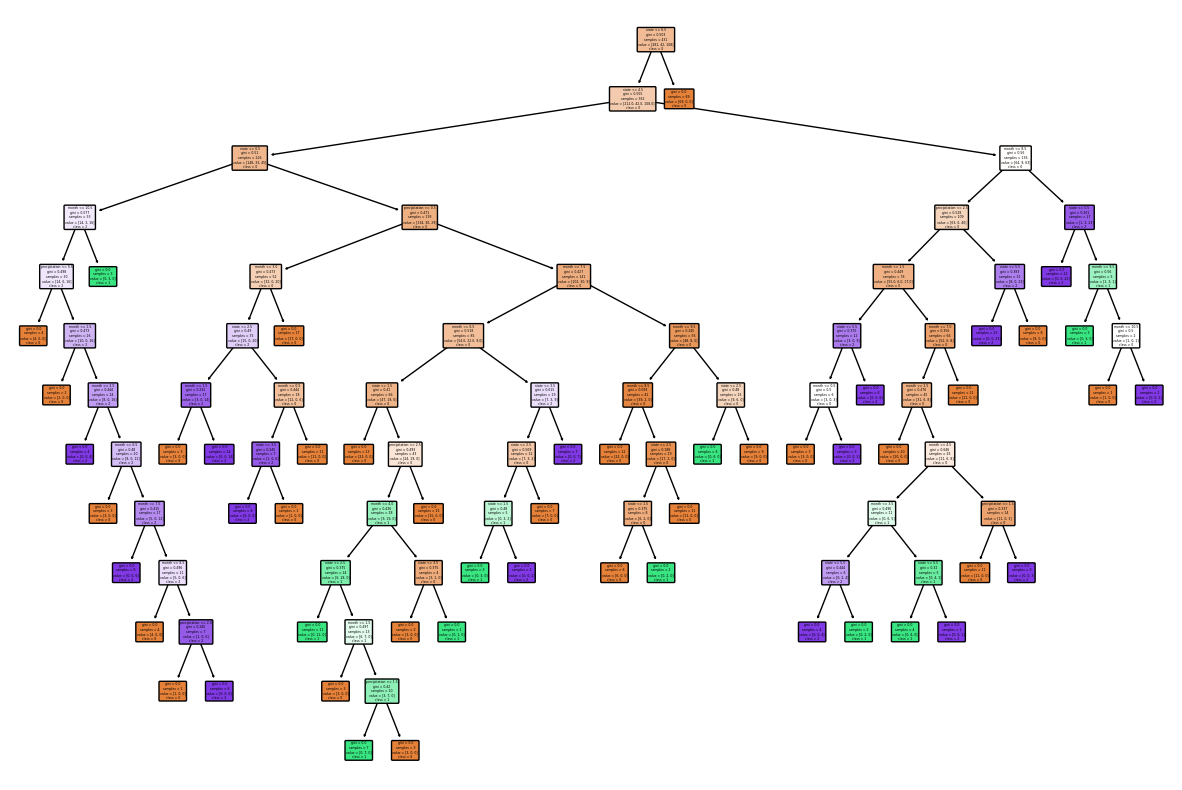

In [27]:

#%% Train  Decision tree for disaster breakdown
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import pandas as pd

# Assuming df_month is your DataFrame
# Make sure to encode categorical variables into numerical values
le_month = LabelEncoder()
le_state = LabelEncoder()
le_disaster = LabelEncoder()

df_month['month'] = le_month.fit_transform(df_month['month'])
df_month['state'] = le_state.fit_transform(df_month['state'])
df_month['disaster'] = le_disaster.fit_transform(df_month['disaster'])

# Define features (X) and target variable (y)
X = df_month[['month', 'state', 'disaster', 'precipitation']]
y = df_month['break_rate']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Create a Decision Tree model
model = DecisionTreeClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report_str)


from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Assuming 'model' is your trained Decision Tree model
class_names_str = list(map(str, model.classes_))

plt.figure(figsize=(15, 10))
plot_tree(model, feature_names=list(X.columns), class_names=class_names_str, filled=True, rounded=True)
plt.show()



Accuracy NB: 0.6851851851851852
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.99      0.81        75
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00        22

    accuracy                           0.69       108
   macro avg       0.23      0.33      0.27       108
weighted avg       0.48      0.69      0.56       108



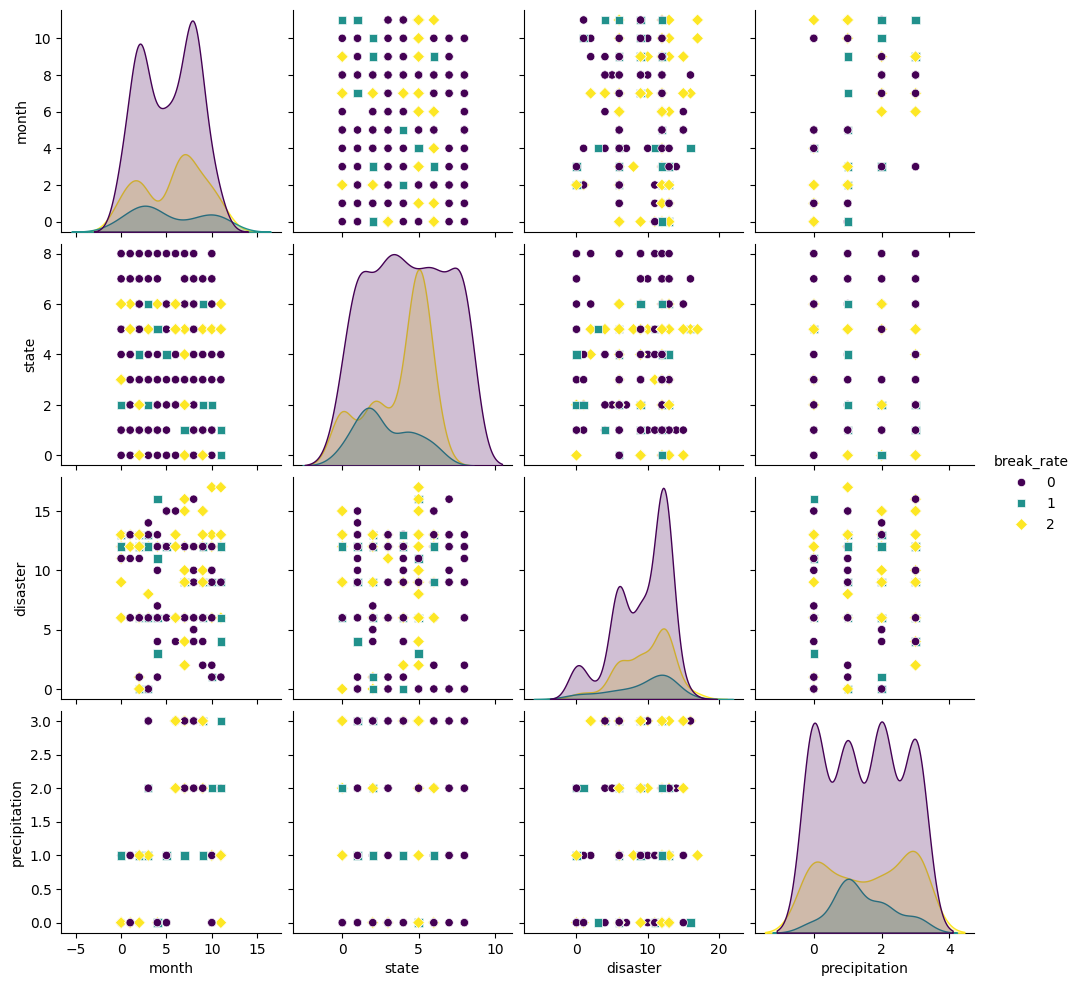

In [28]:
#%% Train  naive-bayes for disaster breakdown

#%%
# Import necessary libraries for Naive Bayes

from sklearn.naive_bayes import GaussianNB


# Create a Naive Bayes model (Gaussian Naive Bayes for continuous features)
model = GaussianNB()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy NB: {accuracy}")
print("Classification Report:\n", classification_report_str)

import seaborn as sns

# Concatenate features and target variable for training data
train_data = pd.concat([X_train, y_train], axis=1)

# Pair plot
sns.pairplot(train_data, hue='break_rate', palette='viridis', markers=["o", "s", "D"])
plt.show()


In [29]:
#%% Train  DNN for disaster breakdown

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train.values)
y_train_tensor = torch.LongTensor(y_train.values)
X_test_tensor = torch.FloatTensor(X_test.values)
y_test_tensor = torch.LongTensor(y_test.values)

# Create a DataLoader for training and testing data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Define the neural network
class EarthquakeRiskComplexNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(EarthquakeRiskComplexNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x

# Example usage:
hidden_size1 = 64
hidden_size2 = 32
hidden_size3 = 16

# Instantiate the model
input_size = X_train.shape[1]
output_size = len(class_names_str)  # Number of classes
model = EarthquakeRiskComplexNN(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 200
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Evaluate the model
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)

    print(f"Accuracy_NN: {accuracy}")

# Set the model back to training mode
model.train()


from sklearn.metrics import classification_report
import torch

# Assuming you have the true labels (y_test) and predicted labels (predicted)
# Convert tensors to numpy arrays
y_test_np = y_test_tensor.numpy()
predicted_np = predicted.numpy()

# Generate classification report
report = classification_report(y_test_np, predicted_np)

# Print the report
print(report)


Accuracy_NN: 0.8240740740740741
              precision    recall  f1-score   support

           0       0.86      0.89      0.88        75
           1       1.00      0.55      0.71        11
           2       0.67      0.73      0.70        22

    accuracy                           0.82       108
   macro avg       0.84      0.72      0.76       108
weighted avg       0.83      0.82      0.82       108



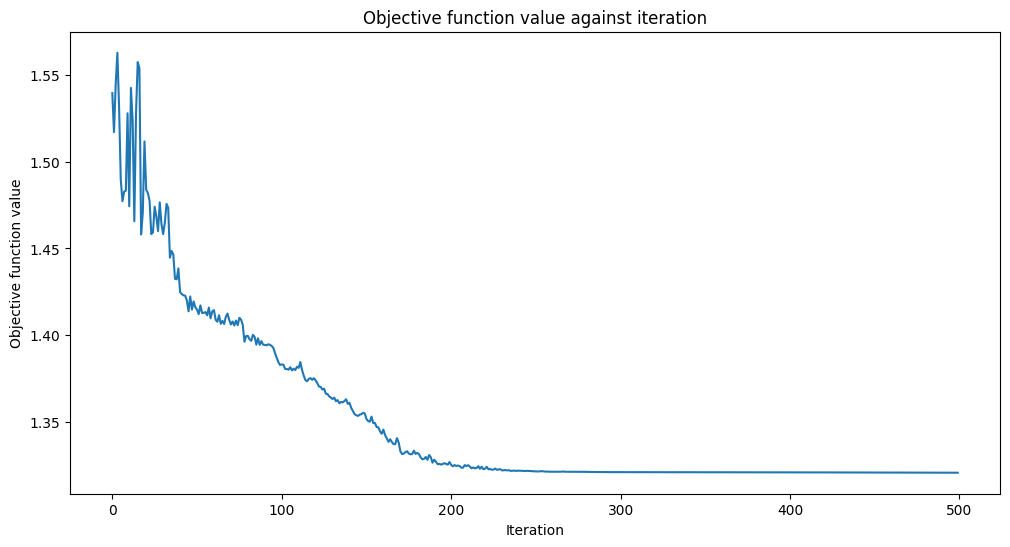

Predicted labels: [1 2 0 1 2 2 2 0 2 0 1 1 0 2 0 0 0 2 0 0 1 0 0 0 0 0 0 0 2 0 0 1 0 0 2 2 0
 2 1 2 0 0 2 0 0 0 0 0 1 0 2 2 0 0 2 0 0 0 0 0 0 0 0 0 2 2 1 0 0 0 0 0 0 0
 0 1 1 2 2 0 0 0 2 0 0 0 0 0 2 0 0 2 0 0 0 0 0 2 0 2 0 0 0 2 1 2 0 0]
Ground truth:     [1 2 1 0 0 0 2 0 0 0 0 0 0 0 0 0 0 2 0 2 1 0 2 0 0 0 0 0 2 0 0 0 0 2 2 2 0
 0 1 0 0 2 0 2 0 0 0 0 1 0 2 0 0 0 1 0 2 0 0 0 2 0 0 0 0 2 0 0 0 0 0 0 2 2
 2 0 2 1 0 0 1 0 1 0 0 2 0 0 0 2 1 2 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]


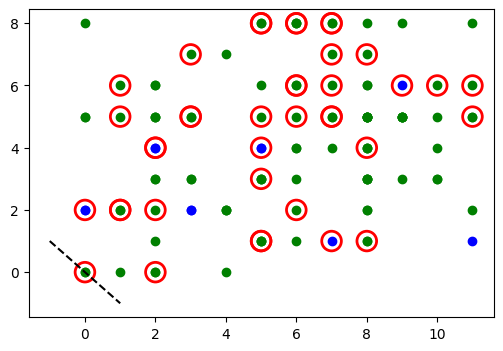

In [30]:
#%% Train  Quantum NN for disaster breakdown

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit

algorithm_globals.random_seed = 42
qc = QNNCircuit(num_qubits=4)
qc.draw("mpl", style="clifford")
estimator_qnn = EstimatorQNN(circuit=qc)
print(X_train.values[0])
estimator_qnn.forward(X_train.values[0], algorithm_globals.random.random(estimator_qnn.num_weights))


# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()


vqc = VQC(
    num_qubits=4,
    optimizer=COBYLA(maxiter=500),
    callback=callback_graph,
)

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

y_cat = np.empty(y_train.values.shape, dtype=str)
y_cat[y_train.values == 0] = "A"
y_cat[y_train.values == 1] = "B"
y_cat[y_train.values == 2] = "C"
print(y_cat)

# fit classifier to data
vqc.fit(X_train.values, y_train.values)


# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(X_train.values,y_train.values)


predict = vqc.predict(X_test.values)
print(f"Predicted labels: {predict}")
print(f"Ground truth:     {y_test.values}")

# evaluate data points
y_predict =predict

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X_test.values, y_test.values, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()




In [31]:
from sklearn.metrics import classification_report
import torch

# Assuming you have the true labels (y_test) and predicted labels (predicted)
# Convert tensors to numpy arrays
y_test_np = y_test.values
predicted_np = predict

# Generate classification report
report = classification_report(y_test_np, predicted_np)

# Print the report
print(report)


              precision    recall  f1-score   support

           0       0.78      0.72      0.75        75
           1       0.42      0.45      0.43        11
           2       0.33      0.41      0.37        22

    accuracy                           0.63       108
   macro avg       0.51      0.53      0.52       108
weighted avg       0.65      0.63      0.64       108

